In [1]:
# =========================================
# Travel Cost Prediction - EDA + ML + DL
# =========================================

# 1. Setup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, accuracy_score, f1_score, confusion_matrix

from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from xgboost import XGBRegressor, XGBClassifier
from lightgbm import LGBMRegressor, LGBMClassifier

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

# Load dataset
df = pd.read_csv("/content/drive/MyDrive/india_travel_dataset_realistic_final.csv")
print(df.head())
print(df.info())


   Trip_ID     Source Destination  Distance_km  Fuel_Price Peak_Season  \
0        1     Indore       Surat          439      109.94          No   
1        2     Indore      Bhopal          219      110.32          No   
2        3    Lucknow      Kerala         2476       96.57         Yes   
3        4     Mumbai       Surat          275      107.53          No   
4        5  Bangalore  Chandigarh         2424      103.28          No   

  Travel_Mode Hotel_Type Food_Preference  Days  Travelers      Cost  \
0       Train   Standard           Vegan    15          2  86371.71   
1         Bus     Budget         Non-Veg     9          2  19491.70   
2      Flight   Standard             Veg    10          1  50507.03   
3         Car     Budget         Non-Veg    10          1  12542.92   
4       Train     Budget         Non-Veg     4          1  15120.75   

  Weather (Sunny, Rainy, Snowy, Cloudy)  \
0                                 Rainy   
1                                 Sunny   

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Shape: (20000, 20)
            Trip_ID   Distance_km    Fuel_Price          Days     Travelers  \
count  20000.000000  20000.000000  20000.000000  20000.000000  20000.000000   
mean   10000.500000   1182.312000    102.613734      8.489900      2.495050   
std     5773.647028    611.146002      5.821284      4.049891      1.315394   
min        1.000000    126.000000     93.000000      2.000000      1.000000   
25%     5000.750000    695.000000     96.750000      5.000000      1.000000   
50%    10000.500000   1106.000000    104.070000      8.000000      2.000000   
75%    15000.250000   1610.250000    107.990000     12.000000      3.000000   
max    20000.000000   3398.000000    112.000000     15.000000      5.000000   

               Cost  Ratings (1–5 stars)  Avg_Cost_per_Traveler  
count  2.000000e+04         20000.000000           20000.000000  
mean   9.076181e+04             3.651550           37269.668274  
std    8.822425e+04             1.115524           29164.729122  
min  

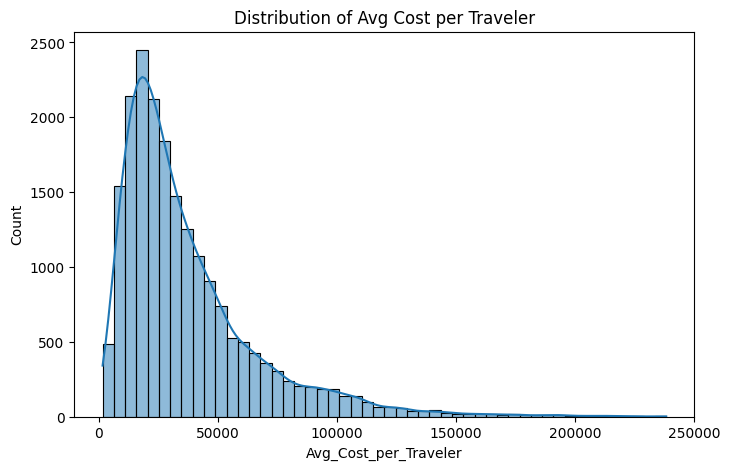

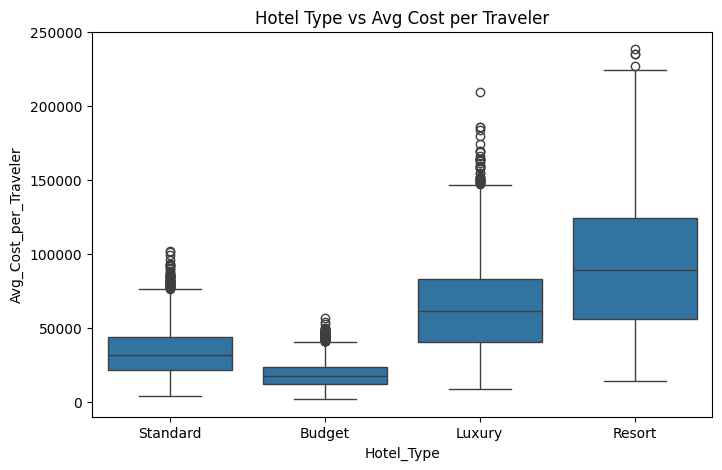

In [3]:
# 2. EDA
print("Shape:", df.shape)
print(df.describe())

# Cost distribution
plt.figure(figsize=(8,5))
sns.histplot(df["Avg_Cost_per_Traveler"], bins=50, kde=True)
plt.title("Distribution of Avg Cost per Traveler")
plt.show()

# Hotel type vs avg cost
plt.figure(figsize=(8,5))
sns.boxplot(x="Hotel_Type", y="Avg_Cost_per_Traveler", data=df)
plt.title("Hotel Type vs Avg Cost per Traveler")
plt.show()


In [4]:
# 3. Feature Engineering

# Target for regression
y_reg = df["Avg_Cost_per_Traveler"]

# Target for classification (Cost Category)
def categorize_cost(c):
    if c < 30000: return "Budget"
    elif c < 80000: return "Mid-range"
    elif c < 150000: return "Premium"
    else: return "Luxury"

df["Cost_Category"] = df["Avg_Cost_per_Traveler"].apply(categorize_cost)
y_clf = df["Cost_Category"]

# Features
X = df.drop(columns=["Trip_ID","Start_Date","End_Date","Cost","Avg_Cost_per_Traveler","Cost_Category"])

# Train/test split
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(X, y_reg, test_size=0.2, random_state=42)
X_train_clf, X_test_clf, y_train_clf, y_test_clf = train_test_split(X, y_clf, test_size=0.2, random_state=42)

# Column types
cat_cols = X.select_dtypes(include="object").columns.tolist()
num_cols = X.select_dtypes(exclude="object").columns.tolist()

# Preprocessor
preprocessor = ColumnTransformer([
    ("num", StandardScaler(), num_cols),
    ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols)
])


In [5]:
# 4. Regression Models

models_reg = {
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(n_estimators=200, random_state=42),
    "XGBoost": XGBRegressor(n_estimators=200, learning_rate=0.1, random_state=42),
    "LightGBM": LGBMRegressor(n_estimators=200, random_state=42)
}

for name, model in models_reg.items():
    pipe = Pipeline([("pre", preprocessor), ("model", model)])
    pipe.fit(X_train_reg, y_train_reg)
    preds = pipe.predict(X_test_reg)
    rmse = np.sqrt(mean_squared_error(y_test_reg, preds))
    r2 = r2_score(y_test_reg, preds)
    print(f"{name}: RMSE={rmse:.2f}, R²={r2:.3f}")


Linear Regression: RMSE=13083.23, R²=0.812
Random Forest: RMSE=8777.81, R²=0.915
XGBoost: RMSE=7844.55, R²=0.932
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001493 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 673
[LightGBM] [Info] Number of data points in the train set: 16000, number of used features: 73
[LightGBM] [Info] Start training from score 36980.726721
LightGBM: RMSE=7657.12, R²=0.936


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


In [6]:
# 5. Classification Models

models_clf = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(n_estimators=200, random_state=42),
    "XGBoost": XGBClassifier(n_estimators=200, learning_rate=0.1, random_state=42),
    "LightGBM": LGBMClassifier(n_estimators=200, random_state=42)
}

# Encode labels
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_train_clf_encoded = le.fit_transform(y_train_clf)
y_test_clf_encoded = le.transform(y_test_clf)


for name, model in models_clf.items():
    pipe = Pipeline([("pre", preprocessor), ("model", model)])
    # Use encoded labels for fitting and evaluation
    pipe.fit(X_train_clf, y_train_clf_encoded if name in ["XGBoost", "LightGBM"] else y_train_clf) # Pass encoded y for XGBoost and LightGBM
    preds = pipe.predict(X_test_clf)

    # Decode predictions back for evaluation if model predicted encoded labels
    if name in ["XGBoost", "LightGBM"]:
        preds = le.inverse_transform(preds)


    acc = accuracy_score(y_test_clf, preds) # Evaluate with original labels
    f1 = f1_score(y_test_clf, preds, average="weighted") # Evaluate with original labels
    print(f"{name}: Accuracy={acc:.3f}, F1={f1:.3f}")

Logistic Regression: Accuracy=0.888, F1=0.887
Random Forest: Accuracy=0.889, F1=0.885
XGBoost: Accuracy=0.898, F1=0.898
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001190 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 673
[LightGBM] [Info] Number of data points in the train set: 16000, number of used features: 73
[LightGBM] [Info] Start training from score -0.632640
[LightGBM] [Info] Start training from score -4.909659
[LightGBM] [Info] Start training from score -0.958416
[LightGBM] [Info] Start training from score -2.551848


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


LightGBM: Accuracy=0.895, F1=0.894


In [7]:
# 6. Deep Learning - Regression
input_dim = preprocessor.fit_transform(X_train_reg).shape[1]

model_dl_reg = Sequential([
    Dense(128, activation="relu", input_dim=input_dim),
    Dropout(0.3),
    Dense(64, activation="relu"),
    Dense(1)
])

model_dl_reg.compile(optimizer="adam", loss="mse", metrics=["mae"])

# Transform data
X_train_dl = preprocessor.fit_transform(X_train_reg)
X_test_dl = preprocessor.transform(X_test_reg)

history = model_dl_reg.fit(X_train_dl, y_train_reg, validation_split=0.2, epochs=10, batch_size=64, verbose=1)

# Evaluate
preds = model_dl_reg.predict(X_test_dl)
rmse = np.sqrt(mean_squared_error(y_test_reg, preds))
r2 = r2_score(y_test_reg, preds)
print(f"Deep Learning Regressor: RMSE={rmse:.2f}, R²={r2:.3f}")


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 2180155392.0000 - mae: 36684.9688 - val_loss: 1964643584.0000 - val_mae: 34395.1992
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1909861760.0000 - mae: 32191.3711 - val_loss: 1056693312.0000 - val_mae: 20601.9355
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 912475776.0000 - mae: 18969.1855 - val_loss: 646693312.0000 - val_mae: 17957.4102
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 674735040.0000 - mae: 18376.5195 - val_loss: 569638272.0000 - val_mae: 17342.1270
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 601428160.0000 - mae: 17463.8359 - val_loss: 503204096.0000 - val_mae: 16134.7666
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 516717792.0000 - mae: 16072.7666 - val_loss: 438583328.0000 - val_mae: 14795.3027
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 474309856.0000 - mae: 15067.6299 - val_loss: 376470336.0000 - val_mae: 13198.2500
Ep

In [8]:
# 7. Deep Learning - Classification

model_dl_clf = Sequential([
    Dense(128, activation="relu", input_dim=input_dim),
    Dropout(0.3),
    Dense(64, activation="relu"),
    Dense(len(df["Cost_Category"].unique()), activation="softmax")
])

model_dl_clf.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

# Encode labels
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train_clf)
y_test_enc = le.transform(y_test_clf)

X_train_dl = preprocessor.fit_transform(X_train_clf)
X_test_dl = preprocessor.transform(X_test_clf)

history = model_dl_clf.fit(X_train_dl, y_train_enc, validation_split=0.2, epochs=10, batch_size=64, verbose=1)

# Evaluate
preds = model_dl_clf.predict(X_test_dl).argmax(axis=1)
acc = accuracy_score(y_test_enc, preds)
f1 = f1_score(y_test_enc, preds, average="weighted")
print(f"Deep Learning Classifier: Accuracy={acc:.3f}, F1={f1:.3f}")


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6674 - loss: 0.7989 - val_accuracy: 0.8662 - val_loss: 0.3233
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8597 - loss: 0.3358 - val_accuracy: 0.8853 - val_loss: 0.2751
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8805 - loss: 0.2747 - val_accuracy: 0.8913 - val_loss: 0.2473
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8905 - loss: 0.2471 - val_accuracy: 0.8881 - val_loss: 0.2453
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9034 - loss: 0.2274 - val_accuracy: 0.8919 - val_loss: 0.2380
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9005 - loss: 0.2281 - val_accuracy: 0.8941 - val_loss: 0.2339
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9102 - loss: 0.2121 - val_accuracy: 0.8963 - val_loss: 0.2345
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9084 - loss: 0.2106 - val_accuracy: 0.

In [9]:
import pickle
from google.colab import files  # use only if you're on Google Colab

# Suppose your model is named 'model'
with open('travel_cost_model.pkl', 'wb') as f:
    pickle.dump(model, f)

# Download the file (for Colab)
files.download('travel_cost_model.pkl')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [10]:
# example: save model and scaler
import joblib
joblib.dump(model_dl_clf, "model.pkl")
joblib.dump(preprocessor, "preprocessor.pkl")  # if you used a pipeline or scaler/encoder


['preprocessor.pkl']